In [9]:
from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility
import numpy as np
import torch
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import view_points, box_in_image
import numpy as np

# 初始化 nuScenes 对象
nusc = NuScenes(version='v1.0-mini', dataroot='../data/nuscenes', verbose=True)


X, Y, Z, W, L, H, SIN_YAW, COS_YAW, VX, VY, VZ = list(range(11))  # undecoded
CNS, YNS = 0, 1  # centerness and yawness indices in quality
YAW = 6  # decoded

classes = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker','vehicle.car','vehicle.bicycle']
pedestrians = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker'] 

def box3d_to_corners(box3d):
    if isinstance(box3d, torch.Tensor):
        box3d = box3d.detach().cpu().numpy()
    corners_norm = np.stack(np.unravel_index(np.arange(8), [2] * 3), axis=1)
    corners_norm = corners_norm[[0, 1, 3, 2, 4, 5, 7, 6]]
    # use relative origin [0.5, 0.5, 0]
    corners_norm = corners_norm - np.array([0.5, 0.5, 0.5])
    corners = box3d[:, None, [W, L, H]] * corners_norm.reshape([1, 8, 3])

    # rotate around z axis
    rot_cos = np.cos(box3d[:, YAW])
    rot_sin = np.sin(box3d[:, YAW])
    rot_mat = np.tile(np.eye(3)[None], (box3d.shape[0], 1, 1))
    rot_mat[:, 0, 0] = rot_cos
    rot_mat[:, 0, 1] = -rot_sin
    rot_mat[:, 1, 0] = rot_sin
    rot_mat[:, 1, 1] = rot_cos
    corners = (rot_mat[:, None] @ corners[..., None]).squeeze(axis=-1)
    corners += box3d[:, None, :3]
    return corners


def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ANY, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data(single image).
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token(image token).
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    #this is for a single sample image
    return data_path, box_list, ann_list, cam_intrinsic #single image info


def view_points(points: np.ndarray, view: np.ndarray, normalize: bool) -> np.ndarray:

    assert view.shape[0] <= 4
    assert view.shape[1] <= 4
    assert points.shape[0] == 3

    viewpad = np.eye(4)
    viewpad[:view.shape[0], :view.shape[1]] = view

    nbr_points = points.shape[1]

    # Do operation in homogenous coordinates.
    points = np.concatenate((points, np.ones((1, nbr_points))))
    points = np.dot(viewpad, points)
    points = points[:3, :]

    if normalize:
        points = points / points[2:3, :].repeat(3, 0).reshape(3, nbr_points)

    return points

def threeD_2_twoD(boxsy,intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]
    
    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)
   
    
    return min_x,max_x,min_y,max_y



def all_3d_to_2d(boxes,anns,intrinsic): #input 3d boxes, annotation key lists, intrinsic matrix (one image)
    x_min=[]
    x_max=[]
    y_min=[]
    y_max =[]
    x_min_3d = []
    x_max_3d = []
    y_min_3d = []
    y_max_3d = []
    center_3d = []
    width=[]
    height=[]
    objects_detected =[]
    orig_objects_detected =[]
    
   
    for j in range(len(boxes)): #iterate through boxes
        box=boxes[j]
        
        if box.name in classes: #if the box.name is in the classes we want to detect
        
            if box.name in pedestrians: 
                orig_objects_detected.append("pedestrian")
            elif box.name == "vehicle.car":
                orig_objects_detected.append("car")
            else:
                orig_objects_detected.append("cyclist")
            #print(box)
            
            visibility = nusc.get('sample_annotation', '%s' %anns[j])['visibility_token'] #give annotation key
            visibility = int(visibility)

            
            if visibility > 1: #more than 40% visible in the panoramic view of the the cameras

                    
                center = box.center #get boxe's center

                center = np.dot(intrinsic,center)
                center_point = center/(center[2]) #convert center point into image plane
                
                
                
                
                if center_point[0] <-100 or center_point[0] > 1700 or center_point[1] <-100 or center_point[1] >1000:
                    #if center of bounding box is outside of the image, do not annotate
                    pass
                
                else:
                    min_x, max_x, min_y, max_y = threeD_2_twoD(box,intrinsic) #converts box into image plane
                    w = max_x - min_x
                    h = max_y - min_y
        
                    
                    x_min.append(min_x)
                    x_max.append(max_x)
                    y_min.append(min_y)
                    y_max.append(max_y)

                    x_min_3d.append(box.center[0]-box.wlh[0]/2)
                    x_max_3d.append(box.center[0]+box.wlh[0]/2)
                    y_min_3d.append(box.center[2]-box.wlh[2]/2)
                    y_max_3d.append(box.center[2]+box.wlh[2]/2)
                    center_3d.append(box.center)

                    width.append(w)
                    height.append(h)
                    if box.name in pedestrians: 
                        objects_detected.append("pedestrian")
                    elif box.name == "vehicle.car":
                        objects_detected.append("car")
                    else:
                        objects_detected.append("cyclist")
                    

            else:
                pass

    return x_min,x_max,y_min,y_max,width,height,objects_detected,orig_objects_detected, [x_min_3d, x_max_3d, y_min_3d, y_max_3d, center_3d] #for a single image

def extract_bounding_box(i,camera_name): #give a single sample number and camera name
    
    '''
    input sample number i, camera name
    outputs min x, max x, min y max y, width and height of bounding box in image coordinates
    2d bounding box
    options for camera name : CAM_FRONT, CAM_FRONT_RIGHT, CAM_FRONT_LEFT, CAM_BACK, CAM_BACK_RIGHT,CAM_BACK_LEFT
    '''
    
    nusc.sample[i] #one image
    
    camera_token = nusc.sample[i]['data']['%s' %camera_name] #one camera, get the camera token 

    path, boxes, anns, intrinsic_matrix = get_sample_data(nusc,'%s' %camera_token) #gets data for one image
    
    x_min, x_max,y_min,y_max,width,height, objects_detected,orig_objects_detected, box_3d_coord = all_3d_to_2d(boxes,anns, intrinsic_matrix)
    
    return x_min, x_max, y_min, y_max, width, height, path, boxes,intrinsic_matrix, objects_detected,orig_objects_detected, box_3d_coord
    #info for a single image
    

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.416 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [22]:
nusc_object = nusc

sd_record = nusc_object.get('sample_data', nusc.sample[0]['data']['CAM_FRONT'])
cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])


cam_intrinsic = np.array(cs_record['camera_intrinsic'])
cam_extrensics = np.array(cs_record['camera_extrinsic'])

def rotate_2d_point(x, y, theta):

    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Original point as a column vector
    point = np.array([x, y])

    # Apply the rotation matrix to the point
    rotated_point = np.dot(rotation_matrix, point)

    # Extract the rotated coordinates
    x_rotated, y_rotated = rotated_point

    return x_rotated, y_rotated

KeyError: 'camera_extrinsic'

In [26]:
import pyquaternion

# Quaternion to pitch, yaw, roll
def quat2euler(q):
    q = pyquaternion.Quaternion(q)
    yaw = q.yaw_pitch_roll[0]
    pitch = q.yaw_pitch_roll[1]
    roll = q.yaw_pitch_roll[2]
    return yaw, pitch, roll

quat2euler(cs_record['rotation'])

(0.7811486481194653, 1.562790697464314, -2.3527660814678413)

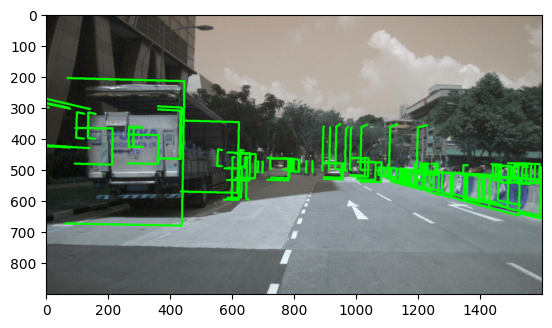

In [4]:
import cv2
import matplotlib.pyplot as plt

sample_token = nusc.sample[0]['token']  # 替換為你的 sample token
sample = nusc.get('sample', sample_token)

# 選擇相機的 sample_data (例如, 'CAM_FRONT')
camera_token = sample['data']['CAM_FRONT']
camera_data = nusc.get('sample_data', camera_token)

# 載入影像
image_path = nusc.get_sample_data_path(camera_token)
image = cv2.imread(image_path)
nusc_img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

# 取得相機校準資料
calibrated_sensor = nusc.get('calibrated_sensor', camera_data['calibrated_sensor_token'])
ego_pose = nusc.get('ego_pose', camera_data['ego_pose_token'])

def threeD_2_twoD2(x, y, z, intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]

    return perspective_x, perspective_y, perspective_z

def twoD_2_threeD2(x_2d, y_2d, z, intrinsic):  # input is a 2D point and depth value
    '''
    Given 2D points, a depth value, and an intrinsic camera matrix,
    outputs the 3D point coordinates.
    '''
    # Create a 3D point in homogeneous coordinates
    x_y_z = np.array([x_2d * z, y_2d * z, z])

    # Compute the inverse of the intrinsic matrix
    intrinsic_inv = np.linalg.inv(intrinsic)

    # Transform the 2D point back into 3D space
    x_y_z_3d = np.dot(intrinsic_inv, x_y_z)

    # Extract the 3D coordinates
    x_3d, y_3d, z_3d = x_y_z_3d

    return x_3d, y_3d, z_3d

# 擷取該幀的所有標註
anns = sample['anns']
for ann_token in anns:
    ann = nusc.get('sample_annotation', ann_token)
    
    # 取得 Box 物件
    box = Box(
        center=ann['translation'],
        size=ann['size'],
        orientation=Quaternion(ann['rotation'])
    )
    
    # 將 box 從世界座標轉換到相機座標
    # 1. 將 box 移動到 ego car 座標系
    box.translate(-np.array(ego_pose['translation']))
    box.rotate(Quaternion(ego_pose['rotation']).inverse)
    
    # 2. 將 box 移動到相機座標系
    box.translate(-np.array(calibrated_sensor['translation']))
    box.rotate(Quaternion(calibrated_sensor['rotation']).inverse)
    
    # 判斷 box 是否在相機視角內，如果是，則繪製到影像上
    camera_intrinsic = np.array(calibrated_sensor['camera_intrinsic'])
 
    # box.render_cv2(image, view=camera_intrinsic, normalize=True)
    corners = box.corners()
    x_ori = corners[0,:]
    y_ori = corners[1,:]
    z_ori = corners[2,:]
    x_arr, y_arr, z_arr = threeD_2_twoD2(x_ori, y_ori, z_ori, camera_intrinsic)
    for i, (x, y) in enumerate(zip(x_arr, y_arr)):
        x = int(x)
        y = int(y)
        if i != 0:
            if i != 4:
                image = cv2.line(image, (prev_x, prev_y), (x, y), (0, 255, 0), 5)
           
        prev_x = x
        prev_y = y


# 顯示並保存影像
plt.imshow(image)

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def inverse_perspective_transform(image, src_points, dst_points, camera_matrix):
    """
    使用相機內參進行逆透視變換。

    :param image: 原始圖像 (numpy array)
    :param src_points: 來源點 (4x2 numpy array)，表示原圖中四個角點
    :param dst_points: 目標點 (4x2 numpy array)，表示目標圖像中四個角點
    :param camera_matrix: 相機內參矩陣 (3x3 numpy array)
    :return: 透視變換後的圖像 (numpy array)
    """
    # 計算透視變換矩陣
    transform_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    
    # 將相機內參應用於透視變換矩陣
    # 計算變換矩陣的校正後矩陣
    # transform_matrix = np.linalg.inv(camera_matrix).dot(transform_matrix).dot(camera_matrix)
    
    # 定義輸出圖像的大小
    height, width = image.shape[:2]
    
    # 使用透視變換矩陣進行圖像變換
    warped_image = cv2.warpPerspective(image, transform_matrix, (2000, 2000))
    
    return warped_image


# 定義相機內參矩陣 (fx, fy, cx, cy)
camera_matrix = cam_intrinsic
# 定義來源點和目標點
src_points = np.array([[0, 900], [500, 400], [1100, 400], [1600, 900]], dtype=np.float32)
# dst_points = np.array([[0, 0], [0, 500], [500, 0], [500, 500]], dtype=np.float32)
dst_points = np.array([[0, 2000], [0, 0], [1100, 0], [1600, 2000]], dtype=np.float32)

# 進行逆透視變換
warped_image = inverse_perspective_transform(nusc_img, src_points, dst_points, camera_matrix)

# 顯示和保存結果
plt.imshow(warped_image)


NameError: name 'nusc_img' is not defined

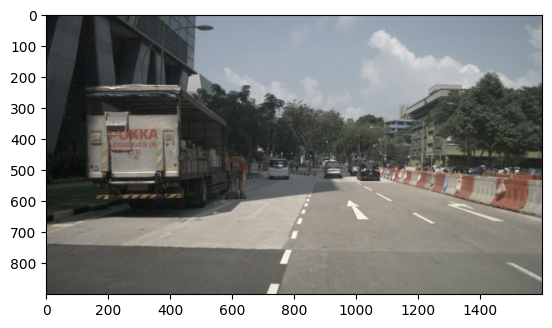

In [8]:
plt.imshow(nusc_img)

In [21]:
cam_intrinsic

array([[1.26641720e+03, 0.00000000e+00, 8.16267020e+02],
       [0.00000000e+00, 1.26641720e+03, 4.91507066e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

ValueError: could not broadcast input array from shape (480,640,480) into shape (480,640)